In [578]:
# Data analysis 
import pandas as pd
import numpy as np
# Data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
# Modeling
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

In [579]:
df = pd.read_csv('bird strikes.csv')

In [580]:
df.head(5)

,RecordID,AircraftType,AirportName,AltitudeBin,MakeModel,NumberStruck,NumberStruckActual,Effect,FlightDate,Damage,...,RemainsSentToSmithsonian,Remarks,WildlifeSize,ConditionsSky,WildlifeSpecies,PilotWarned,Cost,Altitude,PeopleInjured,IsAircraftLarge?
0,202152,Airplane,LAGUARDIA NY,"(1000, 2000]",B-737-400,Over 100,859,Engine Shut Down,11/23/00 0:00,Caused damage,...,False,FLT 753. PILOT REPTD A HUNDRED BIRDS ON UNKN T...,Medium,No Cloud,Unknown bird - medium,N,"30,736",1500,0,Yes
1,208159,Airplane,DALLAS/FORT WORTH INTL ARPT,"(-1, 0]",MD-80,Over 100,424,NaN,7/25/01 0:00,Caused damage,...,False,102 CARCASSES FOUND. 1 LDG LIGHT ON NOSE GEAR ...,Small,Some Cloud,Rock pigeon,Y,0,0,0,No
2,207601,Airplane,LAKEFRONT AIRPORT,"(30, 50]",C-500,Over 100,261,NaN,9/14/01 0:00,No damage,...,False,FLEW UNDER A VERY LARGE FLOCK OF BIRDS OVER AP...,Small,No Cloud,European starling,N,0,50,0,No
3,215953,Airplane,SEATTLE-TACOMA INTL,"(30, 50]",B-737-400,Over 100,806,Precautionary Landing,9/5/02 0:00,No damage,...,False,"NOTAM WARNING. 26 BIRDS HIT THE A/C, FORCING A...",Small,Some Cloud,European starling,Y,0,50,0,Yes
4,219878,Airplane,NORFOLK INTL,"(30, 50]",CL-RJ100/200,Over 100,942,NaN,6/23/03 0:00,No damage,...,False,NO DMG REPTD.,Small,No Cloud,European starling,N,0,50,0,No


In [581]:
df.shape

(25429, 26)

In [582]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25429 entries, 0 to 25428
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   RecordID                  25429 non-null  int64 
 1   AircraftType              25429 non-null  object
 2   AirportName               25429 non-null  object
 3   AltitudeBin               25429 non-null  object
 4   MakeModel                 25429 non-null  object
 5   NumberStruck              25429 non-null  object
 6   NumberStruckActual        25429 non-null  int64 
 7   Effect                    2078 non-null   object
 8   FlightDate                25429 non-null  object
 9   Damage                    25429 non-null  object
 10  Engines                   25195 non-null  object
 11  Operator                  25429 non-null  object
 12  OriginState               24980 non-null  object
 13  FlightPhase               25429 non-null  object
 14  ConditionsPrecipitatio

In [583]:
# Convert 'Cost' variable into integer
df.Cost = df.Cost.str.replace(',', '')
df.Cost = df.Cost.astype(int)
df.Cost.dtype

dtype('int64')

In [584]:
df.Effect.value_counts(dropna=False)

Effect
NaN                      23351
Precautionary Landing     1121
Aborted Take-off           479
Other                      390
Engine Shut Down            88
Name: count, dtype: int64

#### 1. What types of aircrafts are involved in bird strikes?
#### 2. What kinds of birds are involved in bird strikes?
#### 3. What are the flight statuses during bird strikes?
#### 4. What are the geological locations of bird strikes?
#### 5. What times do bird strikes occur?
#### 6. What are the consequences of bird strikes?

In [585]:
df.ConditionsPrecipitation.value_counts(dropna=False)

ConditionsPrecipitation
NaN                23414
Rain                1353
Fog                  475
Snow                  89
Fog, Rain             85
Rain, Snow             6
Fog, Snow              4
Fog, Rain, Snow        3
Name: count, dtype: int64

In [586]:
df.drop(['RecordID'], axis=1).describe()

,NumberStruckActual,Cost,Altitude,PeopleInjured
count,25429.000000,2.542900e+04,25429.000000,25429.000000
mean,2.699634,5.566368e+03,799.028432,0.000826
std,12.825804,1.222388e+05,1740.079843,0.047339
min,1.000000,0.000000e+00,0.000000,0.000000
25%,1.000000,0.000000e+00,0.000000,0.000000
50%,1.000000,0.000000e+00,50.000000,0.000000
75%,1.000000,0.000000e+00,700.000000,0.000000
max,942.000000,1.239775e+07,18000.000000,6.000000


In [587]:
df.Damage.value_counts()

Damage
No damage        22975
Caused damage     2454
Name: count, dtype: int64

The data is fairly unbalanced due to a significant difference between undamaged and damage strikes. Therefore, the descriptive analysis will be between total strikes and damaging strikes.  

In [588]:
# Table with only damaging strikes
df['Cost'] = pd.to_numeric(df['Cost'], errors='coerce') # Convert the 'Cost' column to numeric values, replacing any non-numeric entries with NaN
df_dmg = df[(df['Damage'] != 'No damage') | (df['Cost'] > 0)]
df_dmg.head(5)

,RecordID,AircraftType,AirportName,AltitudeBin,MakeModel,NumberStruck,NumberStruckActual,Effect,FlightDate,Damage,...,RemainsSentToSmithsonian,Remarks,WildlifeSize,ConditionsSky,WildlifeSpecies,PilotWarned,Cost,Altitude,PeopleInjured,IsAircraftLarge?
0,202152,Airplane,LAGUARDIA NY,"(1000, 2000]",B-737-400,Over 100,859,Engine Shut Down,11/23/00 0:00,Caused damage,...,False,FLT 753. PILOT REPTD A HUNDRED BIRDS ON UNKN T...,Medium,No Cloud,Unknown bird - medium,N,30736,1500,0,Yes
1,208159,Airplane,DALLAS/FORT WORTH INTL ARPT,"(-1, 0]",MD-80,Over 100,424,NaN,7/25/01 0:00,Caused damage,...,False,102 CARCASSES FOUND. 1 LDG LIGHT ON NOSE GEAR ...,Small,Some Cloud,Rock pigeon,Y,0,0,0,No
6,221697,Airplane,NEW CASTLE COUNTY,"(100, 200]",LEARJET-25,Over 100,227,Other,8/17/03 0:00,Caused damage,...,True,NaN,Small,No Cloud,European starling,N,1481711,150,0,No
7,236635,Airplane,WASHINGTON DULLES INTL ARPT,"(50, 100]",A-320,Over 100,320,Other,3/1/06 0:00,Caused damage,...,False,WS ASSISTED IN CLEAN-UP OF 273 STARLINGS AND 1...,Small,Some Cloud,European starling,Y,1483141,100,0,No
11,205958,Airplane,CHICAGO O'HARE INTL ARPT,"(1000, 2000]",FOKKER F100,2 to 10,9,NaN,1/20/00 0:00,Caused damage,...,False,"JUST OUTSIDE OF WILLT ON VISUAL APCH, WE FLEW ...",Large,No Cloud,Canada goose,N,0,1700,0,No


# Descriptive Statistics

## 1. What types of aircrafts are involved in bird strikes?

In [589]:
df.Engines.value_counts()

Engines
2    23002
1     1240
3      564
4      388
C        1
Name: count, dtype: int64

In [590]:
# Strike frequency by aircraft engine count
engine = df[df.Engines != 'C'].Engines.value_counts()
engine = pd.DataFrame(engine).reset_index()
engine

,Engines,count
0,2,23002
1,1,1240
2,3,564
3,4,388


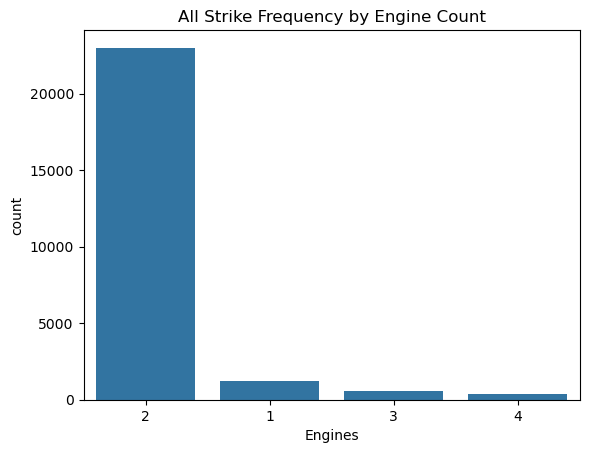

In [591]:
# Plotting Strike Frequency vs. Engine Count
sns.barplot(engine,
            x = 'Engines',
            y = 'count')
plt.title('All Strike Frequency by Engine Count')
plt.show();

In [592]:
# Damaging strike frequency by aircraft engine count
engine_dmg = df_dmg[df_dmg.Engines != 'C'].Engines.value_counts()
engine_dmg = pd.DataFrame(engine_dmg).reset_index()

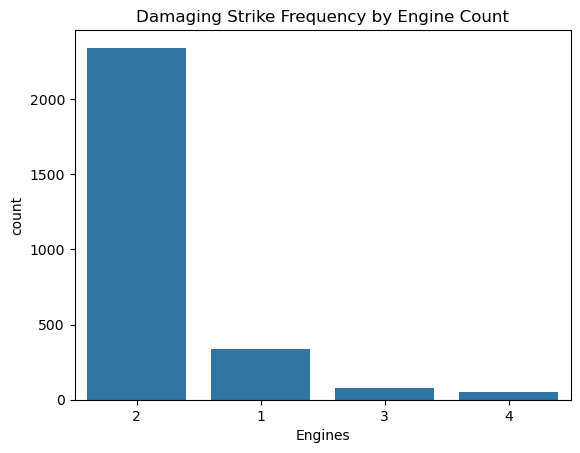

In [593]:
# Plotting the frequency of damaging strikes by engine count
sns.barplot(engine_dmg,
            x = 'Engines',
            y = 'count')
plt.title('Damaging Strike Frequency by Engine Count')
plt.show();

Aircraft with two engines experience the highest number of both total and damaging strikes, likely due to their abundance. In comparison to three- and four-engine aircraft, single-engine aircraft are disproportionately affected by damaging strikes. Without a backup engine, single-engine aircraft may be more vulnerable to damage, once struck. 

In [594]:
# Combing all strike count and damaging strike count into a table
engine_merged = pd.merge(engine, engine_dmg, left_on = ['Engines'], right_on = ['Engines'], suffixes = ('','_dmg'))
engine_merged

,Engines,count,count_dmg
0,2,23002,2342
1,1,1240,336
2,3,564,77
3,4,388,52


In [595]:
# Calculating damaging strike proportion
engine_merged['Damage Rate'] = engine_merged['count_dmg'] / engine_merged['count']

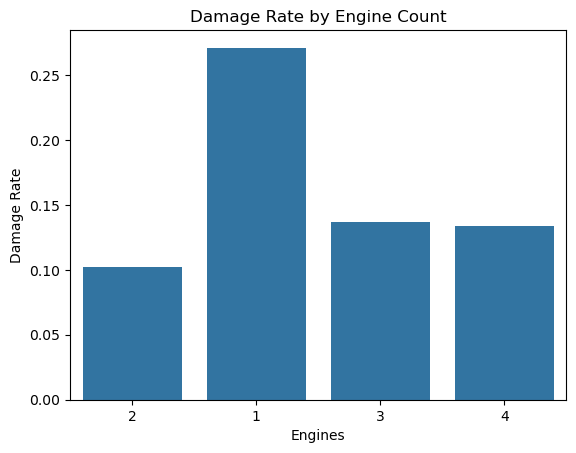

In [596]:
# Plotting Strike Rate vs. Engine Count
sns.barplot(engine_merged,
            x = 'Engines',
            y = 'Damage Rate')
plt.title('Damage Rate by Engine Count')
plt.show();

The bar plot above illustrates the rate of damage occurring once an aircraft is struck. It indicates that single-engine airplanes are the most vulnerable to damage when struck.

## What kinds of birds are involved in bird strikes?

Analyze bird species and sizes

In [597]:
# top 10 bird species - all strikes
species = df.groupby(['WildlifeSpecies', 'WildlifeSize']).size().reset_index(name='count')
species = species.sort_values(by='count', ascending=False).head(10)
species

,WildlifeSpecies,WildlifeSize,count
312,Unknown bird - small,Small,10436
311,Unknown bird - medium,Medium,4296
195,Mourning dove,Small,897
115,European starling,Small,885
309,Unknown bird - large,Large,793
264,Rock pigeon,Small,592
27,Barn swallow,Small,579
169,Killdeer,Small,470
11,American kestrel,Small,443
255,Red-tailed hawk,Medium,409


In [598]:
# top 10 bird species - damaging strikes
species_dmg = df_dmg.groupby(['WildlifeSpecies', 'WildlifeSize']).size().reset_index(name='count')
species_dmg = species_dmg.sort_values(by='count', ascending=False).head(10)
species_dmg

,WildlifeSpecies,WildlifeSize,count
147,Unknown bird - medium,Medium,573
148,Unknown bird - small,Small,454
145,Unknown bird - large,Large,291
36,Canada goose,Large,215
117,Red-tailed hawk,Medium,107
144,Turkey vulture,Large,99
124,Rock pigeon,Small,88
158,White-tailed deer,Large,79
92,Mourning dove,Small,64
56,European starling,Small,55


In [599]:
# Removing unrelated species in top 10 bird species - damaging strikes
df_dmg = df_dmg[df_dmg['WildlifeSpecies'] != 'White-tailed deer'] 
species_dmg = df_dmg.groupby(['WildlifeSpecies', 'WildlifeSize']).size().reset_index(name='count')
species_dmg = species_dmg.sort_values(by='count', ascending=False).head(10)
species_dmg

,WildlifeSpecies,WildlifeSize,count
147,Unknown bird - medium,Medium,573
148,Unknown bird - small,Small,454
145,Unknown bird - large,Large,291
36,Canada goose,Large,215
117,Red-tailed hawk,Medium,107
144,Turkey vulture,Large,99
124,Rock pigeon,Small,88
92,Mourning dove,Small,64
56,European starling,Small,55
87,Mallard,Medium,48


Comparing the two tables above, damaging strikes predominantly involve larger species compared to all strikes. This trend likely stems from the higher impact larger species can cause upon striking.

The tables and graphs below further confirm this observation: strikes that result in damage are primarily attributed to larger species, whereas smaller species account for the majority of overall strikes.

In [600]:
# Size distribution of all strikes
size = df.WildlifeSize.value_counts(normalize = True).reset_index()
size

,WildlifeSize,proportion
0,Small,0.684730
1,Medium,0.233474
2,Large,0.081796


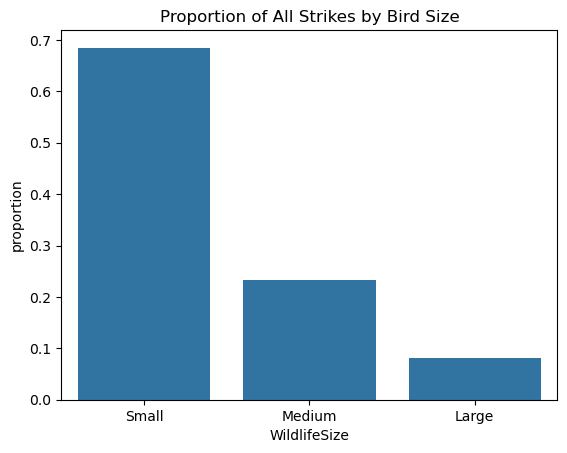

In [601]:
# Plotting the proportion of different bird sizes in all strikes
sns.barplot(data = size, 
            x = 'WildlifeSize',
            y = 'proportion'
           )
plt.title('Proportion of All Strikes by Bird Size');

In [602]:
# Size distribution of all damaging strikes
size_dmg = df_dmg.WildlifeSize.value_counts(normalize = True).reset_index()
size_dmg

,WildlifeSize,proportion
0,Medium,0.367089
1,Small,0.317179
2,Large,0.315732


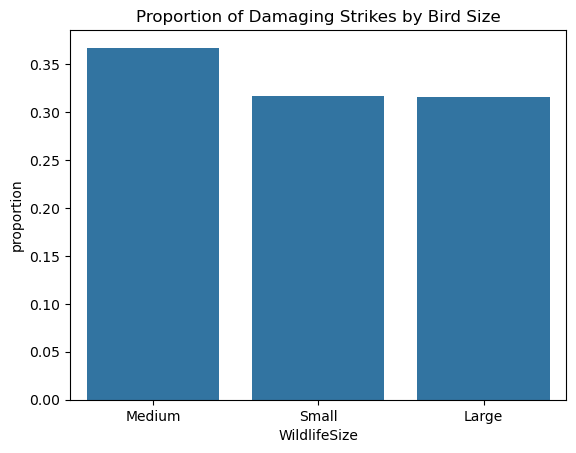

In [603]:
# Plotting the proportion of different bird sizes in damaging strikes
sns.barplot(data = size_dmg, 
            x = 'WildlifeSize',
            y = 'proportion'
           )
plt.title('Proportion of Damaging Strikes by Bird Size');

## What is the distribution of costs across different flight phases?

Analyze flight phase and cost

In [604]:
# Strike count, average cost, and total cost of all strikes by flight phase.
phase = df.groupby('FlightPhase').agg(
    Strike_Count = ('FlightPhase', 'size'),
    Average_Cost = ('Cost', 'mean'),
    Total_Cost = ('Cost', 'sum')
).reset_index()
phase

,FlightPhase,Strike_Count,Average_Cost,Total_Cost
0,Approach,10382,2894.480543,30050497
1,Climb,4429,13143.659968,58213270
2,Descent,776,5285.177835,4101298
3,Landing Roll,5047,3924.148603,19805178
4,Parked,10,0.000000,0
5,Take-off run,4711,6220.735513,29305885
6,Taxi,74,960.135135,71050


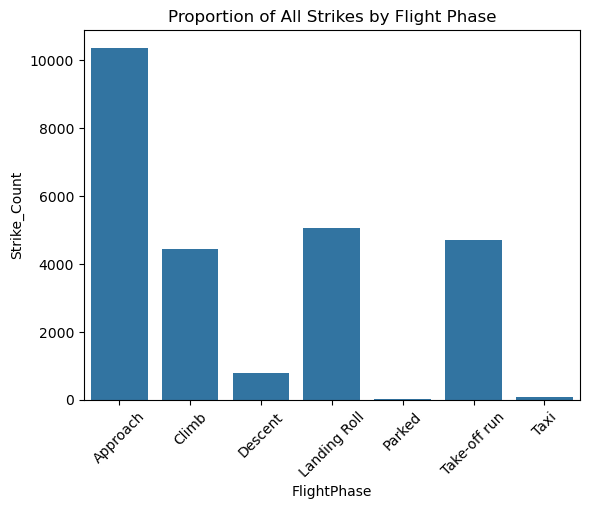

In [605]:
# Plotting the proportion of all  strikes by flight phase
sns.barplot(data = phase, 
            x = 'FlightPhase',
            y = 'Strike_Count'
           )
plt.title('Proportion of All Strikes by Flight Phase');
plt.xticks(rotation=45)
plt.show();

In [606]:
# Strike count, average cost, and total cost of damaging strikes by flight phase.
phase_dmg = df_dmg.groupby('FlightPhase').agg(
    Strike_Count = ('FlightPhase', 'size'),
    Average_Cost = ('Cost', 'mean'),
    Total_Cost = ('Cost', 'sum')
).reset_index()
phase_dmg

,FlightPhase,Strike_Count,Average_Cost,Total_Cost
0,Approach,1182,25350.672589,29964495
1,Climb,772,75313.670984,58142154
2,Descent,172,23844.755814,4101298
3,Landing Roll,226,16422.101770,3711395
4,Parked,2,0.000000,0
5,Take-off run,406,69953.507389,28401124
6,Taxi,5,14210.000000,71050


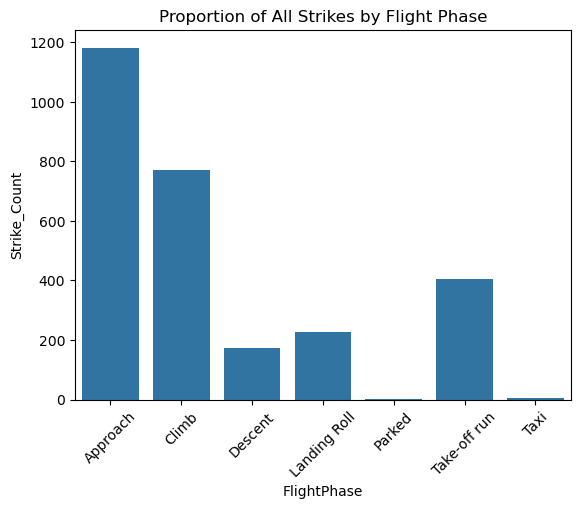

In [607]:
# Plotting the proportion of damaging strikes by flight phase
sns.barplot(data = phase_dmg, 
            x = 'FlightPhase',
            y = 'Strike_Count'
           )
plt.title('Proportion of All Strikes by Flight Phase');
plt.xticks(rotation=45)
plt.show();

The graphs above show that the majority of strikes occur during the approach phase, which also sees the highest frequency of damaging strikes. A disproportionate increase in the climbing phase suggests that damaging strikes are more prevalent here than in other phases, excluding the approach. Conversely, damaging strikes are less frequent during the landing roll phase compared to the other phases.

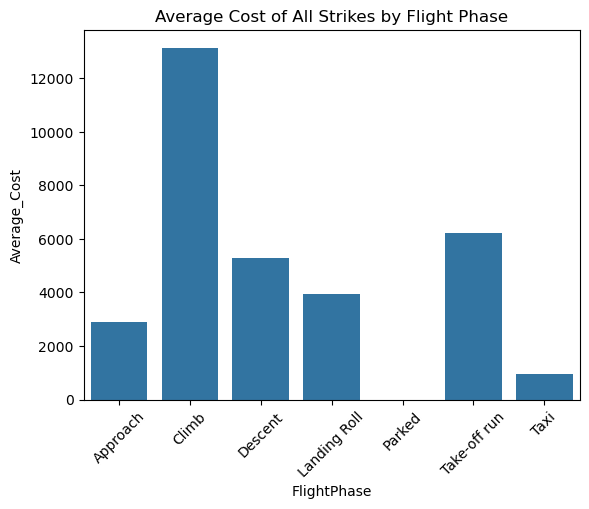

In [608]:
# Plotting the average cost of all strikes by flight phase
sns.barplot(data = phase, 
            x = 'FlightPhase',
            y = 'Average_Cost'
           )
plt.title('Average Cost of All Strikes by Flight Phase');
plt.xticks(rotation=45)
plt.show();

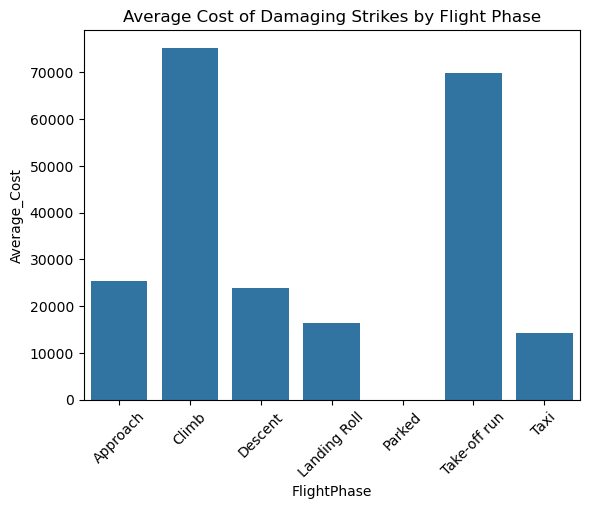

In [609]:
# Plotting the average cost of damaging strikes by flight phase
sns.barplot(data = phase_dmg, 
            x = 'FlightPhase',
            y = 'Average_Cost'
           )
plt.title('Average Cost of Damaging Strikes by Flight Phase');
plt.xticks(rotation=45)
plt.show();

Comparing the two graphs above, damaging strikes cost more, specifically during the climbing phase and take-off run. Considering that climbing, landing, and take-off phases have a similar number of all strike cases, the disproportional change in the average cost of damaging strikes during take off should be further investigated. As such, priority should be given to addressing these two phases, with tailored countermeasures for each scenario.

In [610]:
# Finding proportional cost of damaging strikes by flight phase
phase_merged = pd.merge(phase, phase_dmg, left_on='FlightPhase', right_on='FlightPhase', suffixes = ('', '_dmg'))
phase_merged = phase_merged.drop(['Strike_Count', 'Average_Cost', 'Strike_Count_dmg', 'Average_Cost_dmg'], axis  = 1)
phase_merged['Proportional_Cost'] = phase_merged.Total_Cost_dmg / phase_merged.Total_Cost

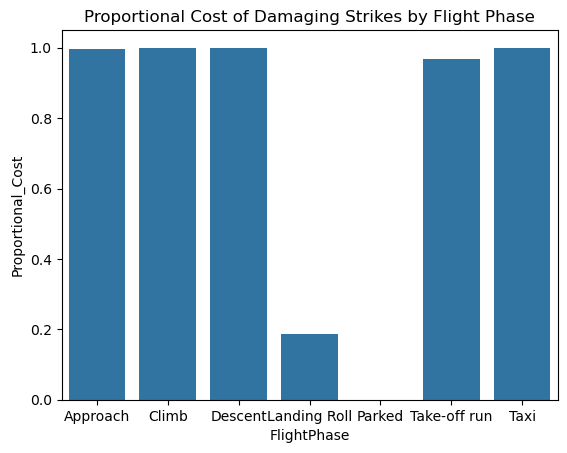

In [611]:
# Plotting proportional cost of damaging strikes by flight phase
sns.barplot(data = phase_merged,
            x = 'FlightPhase',
            y = 'Proportional_Cost')
plt.title('Proportional Cost of Damaging Strikes by Flight Phase')
plt.show()

Understandably, most costs arise from damaging strikes. However, intriguingly, a significant portion of costs during the landing roll phase stems from non-damaging cases. I hypothesize that these strikes cause flight delays, leading to increased inspection costs or passenger compensation. Since this phase occurs on the ground, it may be more feasible to implement preventive measures to deter birds effectively.

## What are the geological locations of bird strikes? 

In [612]:
# List of non US State
non_us_state = ['Puerto Rico', 'Virgin Islands','Prince Edward Island', 'Ontario', 'British Columbia' ,'Quebec', 'Alberta', 'Newfoundland and Labrador', 'Saskatchewan']

In [613]:
state_abbreviations = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", 
    "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA", 
    "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", 
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", 
    "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", 
    "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", 
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", 
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", 
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", 
    "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}


In [614]:
# Frequency of struck plane origin 
state = df.OriginState.value_counts() 
state = pd.DataFrame(state).reset_index()
state = state[~state['OriginState'].isin(non_us_state)]
state['OriginState'] = state['OriginState'].replace(state_abbreviations)

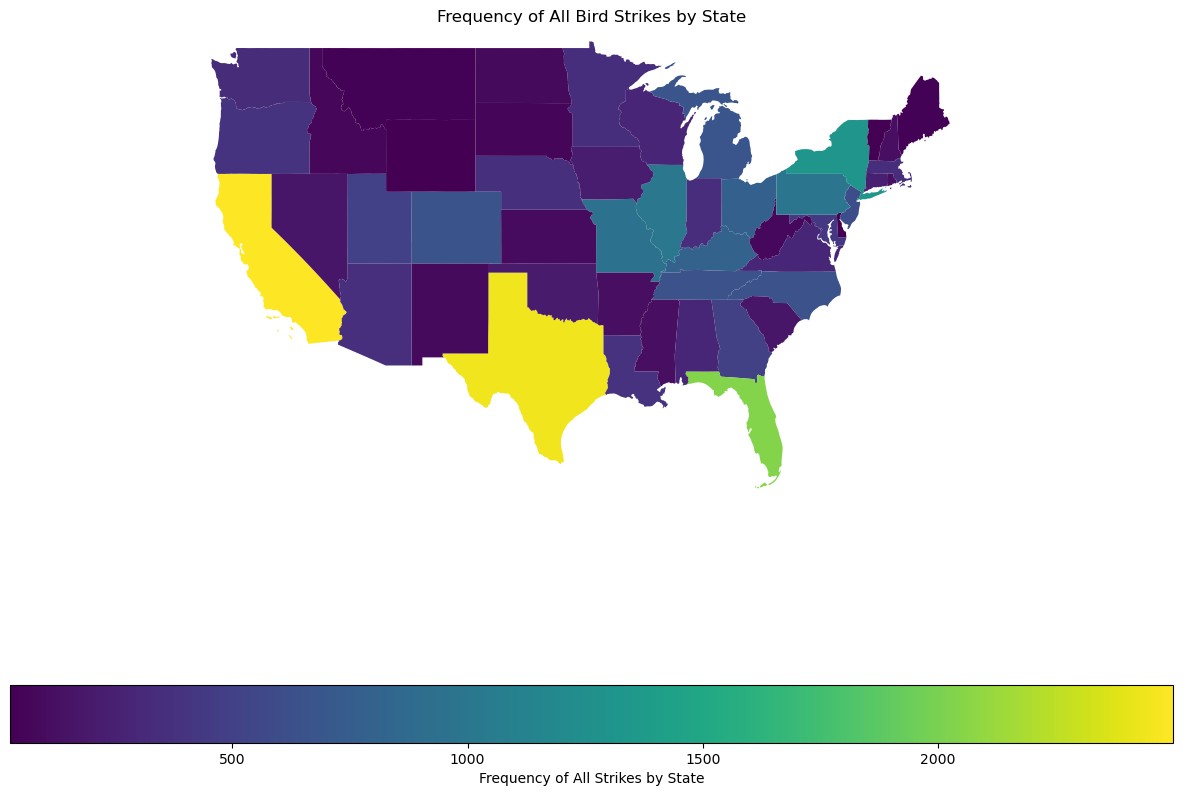

In [615]:
# Graphing the frequency of all strikes by state
# Load the shapefile data
gdf = gpd.read_file('cb_2022_us_state_20m.shp')

gdf = gdf.set_index('STUSPS')  # Set the state abbreviation as index

# Merge the dataframe with the GeoDataFrame on the state abbreviation
merged = gdf.join(state.set_index('OriginState'))

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(column='count', ax=ax, legend=True,
            legend_kwds={'label': "Frequency of All Strikes by State",
                         'orientation': "horizontal"})
# Adjust graph
ax.set_title('Frequency of All Bird Strikes by State')
ax.set_axis_off()
ax.set_xlim(-130, -60) 
ax.set_ylim(20, 50)
plt.show()

Bird strikes are most frequent in California, Texas, and Florida, which are located in the southern United States. This trend may be attributed to these states being key points along migratory bird paths, as many bird species travel through these regions during seasonal transitions. Additionally, these areas likely have higher bird populations, which increases the likelihood of collisions.

A secondary cluster of bird strikes occurs in the Northwestern and Midwestern states. This pattern may reflect the abundance of suitable habitats for birds, such as wetlands and forests, which attract both migratory and resident species. These regions may also experience higher strike rates due to their proximity to busy air traffic routes.

In [616]:
# Frequency of damaging struck plane origin
state_dmg = df_dmg.OriginState.value_counts() 
state_dmg = pd.DataFrame(state_dmg).reset_index()
state_dmg = state_dmg[~state_dmg['OriginState'].isin(non_us_state)]
state_dmg['OriginState'] = state_dmg['OriginState'].replace(state_abbreviations)

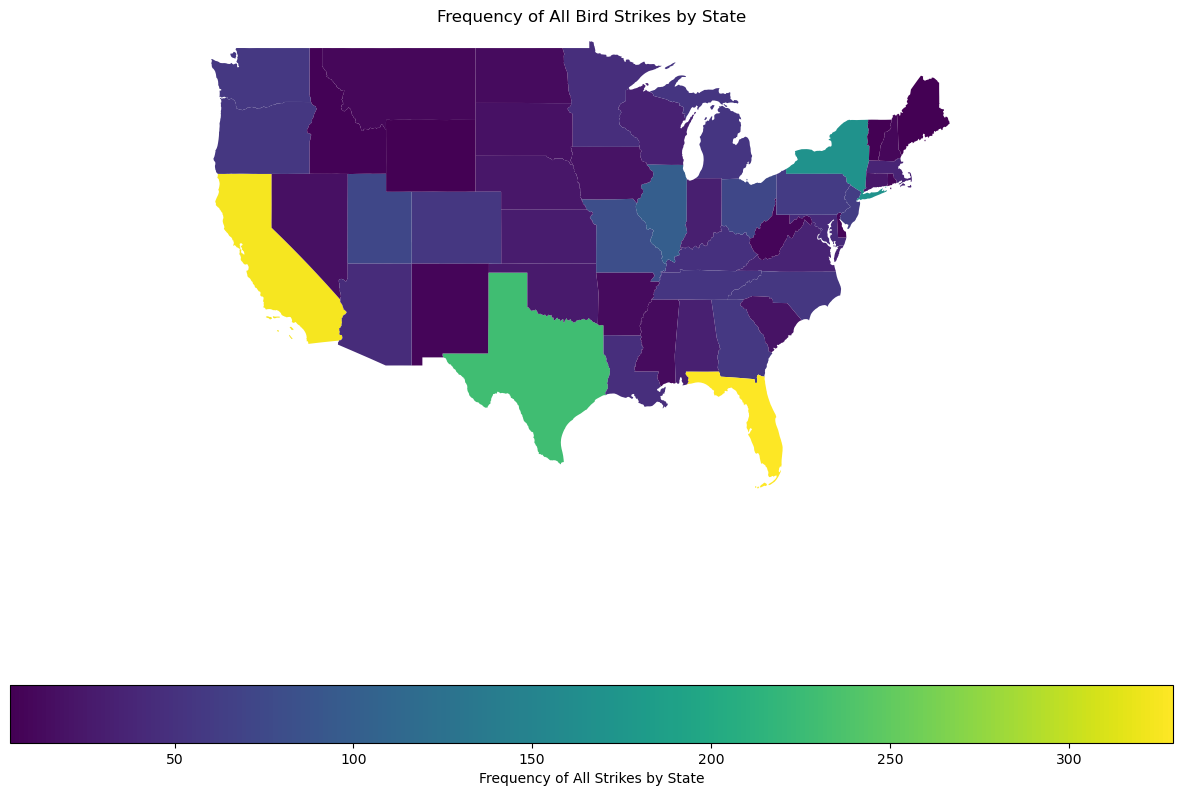

In [617]:
# Graphing the frequency of damaging bird strikes by state
# Load the shapefile data
gdf = gpd.read_file('cb_2022_us_state_20m.shp')

gdf = gdf.set_index('STUSPS')  # Set the state abbreviation as index

# Merge the dataframe with the GeoDataFrame on the state abbreviation
merged = gdf.join(state_dmg.set_index('OriginState'))

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(column='count', ax=ax, legend=True,
            legend_kwds={'label': "Frequency of All Strikes by State",
                         'orientation': "horizontal"})

# Adjust graph
ax.set_title('Frequency of All Bird Strikes by State')
ax.set_axis_off()
ax.set_xlim(-130, -60) 
ax.set_ylim(20, 50)
plt.show()

The map highlighting damaging strikes shows that California, Florida, and Texas remain key areas of concern, as they continue to exhibit a high frequency of damaging strikes. However, it's interesting to note that Oregon and Washington, despite having fewer overall strikes than states in the secondary cluster, show a higher concentration of damaging strikes. This suggests that while these states experience fewer bird strikes overall, the strikes they do have may be more severe or involve more vulnerable aircraft, warranting further investigation and targeted mitigation efforts in these regions.

## What times do bird strikes occur? 

In [618]:
# Creating a table of date when a bird strike
time = df.FlightDate.copy()
time = pd.DataFrame(time)
time['FlightDate'] = pd.to_datetime(time['FlightDate'], format='%m/%d/%y %H:%M')

# Creating a table of dates when a bird strike damage
time_dmg = df_dmg.FlightDate.copy()
time_dmg = pd.DataFrame(time_dmg)
time_dmg['FlightDate'] = pd.to_datetime(time_dmg['FlightDate'], format='%m/%d/%y %H:%M')

In [648]:
# Adding day, month, year to all-strike table
time['Year'] = time['FlightDate'].dt.year
time['Month'] = time['FlightDate'].dt.month
time['Day'] = time['FlightDate'].dt.day
time['YearMonth'] = time['FlightDate'].dt.to_period('M')

# Adding day, month, year to table damaging-strike table
time_dmg['Year'] = time_dmg['FlightDate'].dt.year
time_dmg['Month'] = time_dmg['FlightDate'].dt.month
time_dmg['Day'] = time_dmg['FlightDate'].dt.day
time_dmg['YearMonth'] = time_dmg['FlightDate'].dt.to_period('M')

The frequency of bird strikes begins to rise in March, peaking during the summer months of July, August, and September, before sharply declining after October. This trend aligns with the summer travel season, which sees a peak in air travel due to vacation demand. The highest frequency of strikes coincides with both the height of bird migration (especially southward in fall) and the increased number of flights during the summer months. As the migration subsides and air travel drops off after October, the number of strikes falls significantly.

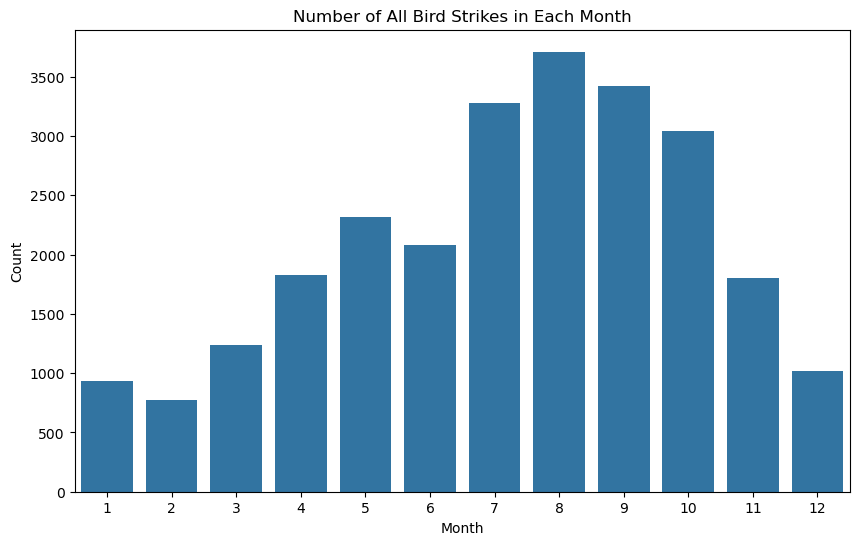

In [620]:
# Plotting all bird strikes by month
monthly_strikes = time.groupby('Month').size().reset_index(name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Count', data=monthly_strikes)
plt.title('Number of All Bird Strikes in Each Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

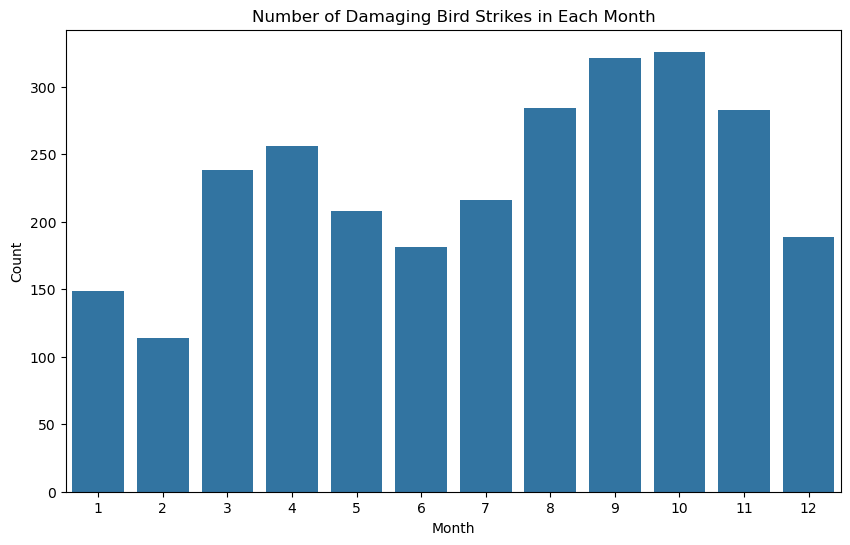

In [621]:
# Plotting damaging bird strikes by month
monthly_strikes_dmg = time_dmg.groupby('Month').size().reset_index(name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Count', data=monthly_strikes_dmg)
plt.title('Number of Damaging Bird Strikes in Each Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

Damaging strikes occur more frequently during the spring and summer months, which aligns with my explanation of increased travel demand and bird migration patterns. The higher number of damaging strikes in the spring could be attributed to the large volume of birds migrating, while the elevated flight frequency in the summer likely contributes to an increased number of damaging strikes. The combination of these factors explains the seasonal spike in damaging bird strikes during these months.

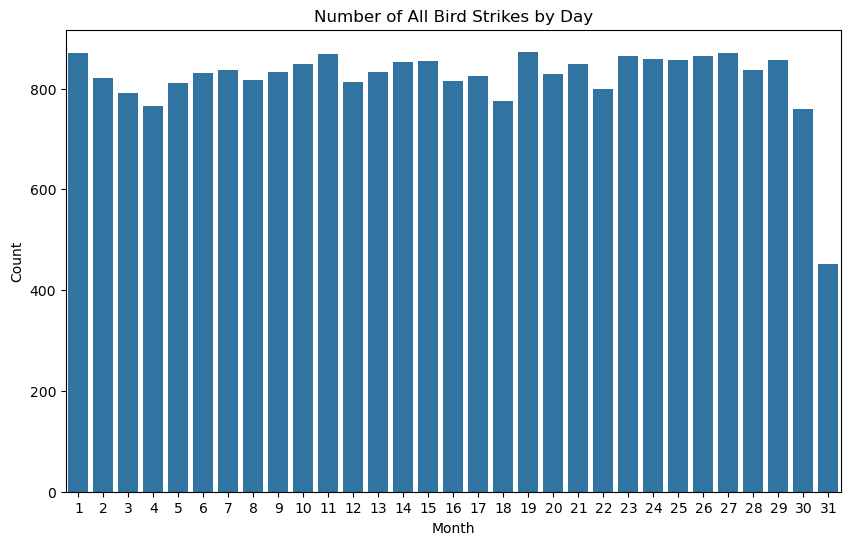

In [622]:
# Plotting all bird strikes by day
daily_strikes = time.groupby('Day').size().reset_index(name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='Count', data=daily_strikes)
plt.title('Number of All Bird Strikes by Day')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

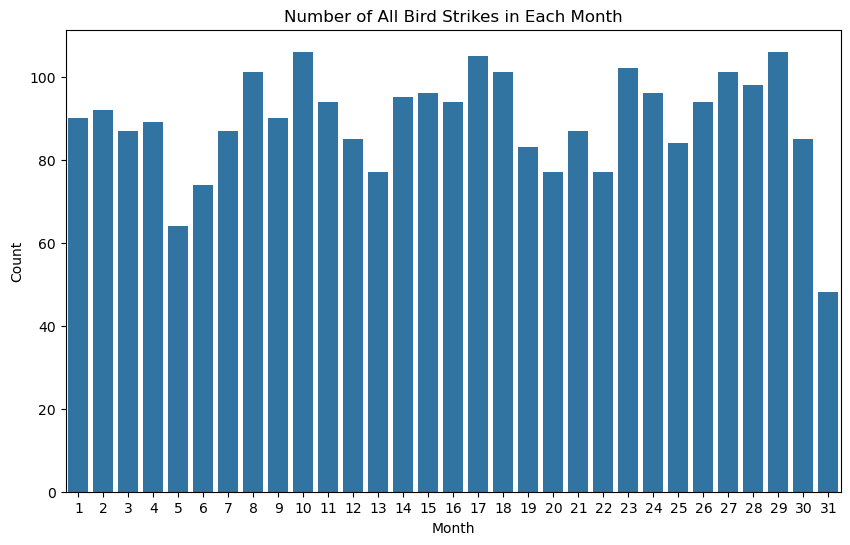

In [623]:
# Plotting damaging bird strikes by day
daily_strikes_dmg = time_dmg.groupby('Day').size().reset_index(name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='Count', data=daily_strikes_dmg)
plt.title('Number of All Bird Strikes in Each Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

It's fascinating to observe that damaging bird strikes vary across the days of a month. This variation is likely influenced by flight schedules or patterns on specific days.

# Inferential Statistics

In [ ]:
sentiment_trends.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Sentiment Trends Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

1. Can we predict whether a bird strike will result in damage to a flight?
2. How can we predict the financial cost of damage caused by bird strikes on a flight?

In [624]:
pred_df = df.copy()
pred_df['FlightDate'] = pd.to_datetime(pred_df['FlightDate'], format='%m/%d/%y %H:%M')
pred_df['Month'] = pred_df['FlightDate'].dt.month
# New column: 0 if bird strike has no consequence and 1 if there is cost or damage
pred_df['Outcome'] = pred_df.apply(lambda row: 1 if row['Damage'] == 'Caused Damage' or row['Cost'] > 0 else 0, axis=1)
# Change Engines data type to integer
pred_df = pred_df.dropna(subset=['Engines'])
pred_df = pred_df[pred_df.Engines != 'C']
pred_df.Engines = pred_df.Engines.astype(int)
pred_df.Month = pred_df.Month.astype(int)
pred_outcome = pred_df.copy()
pred_cost = pred_df.copy()

## 1. Can we predict whether a bird strike will result in damage to a flight?

In [625]:
# Hot encoding variables
X = ['OriginState', 'IsAircraftLarge?', 'WildlifeSize', 
     'ConditionsSky', 'NumberStruck', 'FlightPhase',
    'WildlifeSize', 'PilotWarned']

In [626]:
pred_outcome = pd.get_dummies(pred_outcome, columns = X, drop_first=True)
# Drop columns from pred_outcome that exist in df excluding Engines
pred_outcome = pred_outcome.drop(columns=[col for col in df.columns if col not in ['Engines', 'Month', 'Outcome'] and col in pred_outcome.columns])

In [627]:
# Separate the dataset into two subdatasets based on 'Outcome' column
damage_data = pred_outcome[pred_outcome['Outcome'] == 1]
normal_data = pred_outcome[pred_outcome['Outcome'] == 0]

In [628]:
# Undersample the 'normal_data' to match the size of 'damage_data'
undersampled_normal_data = resample(normal_data,
                                    n_samples=len(damage_data),  # Match the number of damage strikes
                                    random_state=1234,  
                                    replace=False)  # No replacement, to get an equal number

In [629]:
# Concatenate the damage data and the undersampled normal data
undersampled_data = pd.concat([damage_data, undersampled_normal_data])

In [630]:
# Separating independent and dependent data
predictors = undersampled_data.drop('Outcome', axis = 1)
predictant = undersampled_data.Outcome

In [631]:
# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(predictors, predictant, test_size=0.2, random_state=1234)

#### Logistic Regression

In [632]:
# Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [633]:
# Initialize the logistic regression model
log_model = LogisticRegression(random_state=1234)
# Fit the model to the training data
log_model.fit(X_train_scaled, y_train)
# Make predictions 
y_pred = log_model.predict(X_test_scaled)

In [634]:
# Accuracy of model
logistic_acc = accuracy_score(y_test, y_pred)
logistic_acc

0.6892177589852009

In [635]:
# Perform 5-fold cross-validation
log_cv_scores = cross_val_score(log_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
log_cv_scores.mean()

0.6805880135695439

In [636]:
# Get predicted probabilities for the positive class (class 1)
y_prob = log_model.predict_proba(X_test_scaled)[:, 1]
# Calculate the ROC AUC score
log_auc = roc_auc_score(y_test, y_prob)
log_auc

0.7515418818129661

In [637]:
log_report = classification_report(y_test, y_pred, output_dict=True)
log_report = pd.DataFrame(log_report).T
log_report

,precision,recall,f1-score,support
0,0.657143,0.718750,0.686567,224.000000
1,0.723684,0.662651,0.691824,249.000000
accuracy,0.689218,0.689218,0.689218,0.689218
macro avg,0.690414,0.690700,0.689196,473.000000
weighted avg,0.692172,0.689218,0.689334,473.000000


#### Random Forest Classification

In [638]:
# RandomForestClassifier 
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [639]:
# Accuracy of model
rf_acc = accuracy_score(y_test, y_pred)
rf_acc

0.7061310782241015

In [640]:
# Perform 5-fold cross-validation
rf_cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
rf_cv_scores.mean()

0.6610182742108863

In [641]:
# Get predicted probabilities for the positive class (class 1)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]
# Calculate the ROC AUC score
rf_auc = roc_auc_score(y_test, y_prob)
rf_auc

0.7569026104417671

In [642]:
rf_report = classification_report(y_test, y_pred, output_dict=True)
rf_report = pd.DataFrame(rf_report).T
rf_report

,precision,recall,f1-score,support
0,0.660377,0.781250,0.715746,224.000000
1,0.764423,0.638554,0.695842,249.000000
accuracy,0.706131,0.706131,0.706131,0.706131
macro avg,0.712400,0.709902,0.705794,473.000000
weighted avg,0.715150,0.706131,0.705268,473.000000


#### K-Nearest Neighbors classification

In [643]:
# K-Nearest Neighbors classification
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
# Make predictions on the test set
y_pred = knn.predict(X_test)

In [644]:
# Accuracy of model
knn_acc = accuracy_score(y_test, y_pred)
knn_acc

0.6448202959830867

In [645]:
# Perform 5-fold cross-validation
knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
knn_cv_scores.mean()

0.6298125113428543

In [646]:
# Get predicted probabilities for the positive class (class 1)
y_prob = knn.predict_proba(X_test)[:, 1]
# Calculate the ROC AUC score
knn_auc = roc_auc_score(y_test, y_prob)
knn_auc

0.6735065261044177

In [647]:
knn_report = classification_report(y_test, y_pred, output_dict=True)
knn_report = pd.DataFrame(knn_report).T
knn_report

,precision,recall,f1-score,support
0,0.615702,0.665179,0.639485,224.00000
1,0.675325,0.626506,0.650000,249.00000
accuracy,0.644820,0.644820,0.644820,0.64482
macro avg,0.645514,0.645842,0.644742,473.00000
weighted avg,0.647089,0.644820,0.645020,473.00000


#### Summary

In [ ]:
summary = {'Model': ['K-Nearest Neighbors', 'Logistic Regression', 'Random Forests'],
           'Accuracy': [knn_acc, logistic_acc, rf_acc],
           'Cross-Validation Accuracy': [knn_cv_scores.mean(), log_cv_scores.mean(), rf_cv_scores.mean()],
           'Testing AUC' : [knn_auc, log_auc, rf_auc]
}
summary = pd.DataFrame(summary)
summary

Based on the comparison of various metrics, the Random Forest classification model currently outperforms the other models. However, it's important to note that these results are derived from base models, with minimal feature engineering or hyperparameter tuning. As such, there is still significant potential for improvement by further refining the model through techniques such as feature engineering, model tuning, and advanced optimization.

## 2. How can we predict the financial cost caused by bird strikes on a flight?

In [ ]:
# pred_cost = pred_cost[pred_cost['Cost'] > 0]

In [ ]:
# Hot encoding variables
X = ['OriginState', 'MakeModel', 'WildlifeSize',
     'ConditionsSky', 'FlightPhase', 'IsAircraftLarge?',
    'WildlifeSize', 'PilotWarned', 'AltitudeBin']

In [ ]:
pred_cost = pd.get_dummies(pred_cost, columns = X, drop_first=True)
# Drop columns from pred_outcome that exist in df excluding Engines
pred_cost = pred_cost.drop(columns=[col for col in df.columns if col not in ['PeopleInjured','Engines', 'Month', 'Outcome', 'NumberStruckActual', 'Cost'] and col in pred_cost.columns])

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data = pred_cost, x = 'Cost', bins = 50)
plt.title('Cost Distribution of All Strikes')
plt.show();

Due to right skew, 'Cost' variable will be transformed.

In [ ]:
# Separating independent and dependent data
predictors = pred_cost.drop('Cost', axis = 1)
# Applying a logarithmic transformation to 'Cost' to address skewness
predictant = pred_cost.Cost
predictant = pd.DataFrame(predictant)
predictant.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(predictors, predictant, test_size=0.2, random_state=1234)

In [ ]:
# Scaling variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['PeopleInjured','NumberStruckActual']])
X_test_scaled = scaler.transform(X_test[['PeopleInjured','NumberStruckActual']])

# Logging 'Cost' to avoid skewing
y_train = np.log1p(y_train.Cost)
y_test = np.log1p(y_test.Cost)

In [ ]:
# Linear Regression
line = LinearRegression()
# Train the model
line.fit(X_train_scaled, y_train)
# Make predictions
y_pred = line.predict(X_test_scaled)

In [ ]:
mean_squared_error(y_test, y_pred)

In [ ]:
r2 = r2_score(y_test, y_pred)
r2

The linear regression model demonstrated good performance in predicting the cost, but R2 is low.

In [ ]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=1234)
# Train the model
rf.fit(X_train, y_train)
# Make predictions
y_pred = rf.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mse

In [ ]:
r2 = r2_score(y_test, y_pred)
r2

In [ ]:
# Reversing log transformation
rmse = np.sqrt(mse)
original_scale_error = np.expm1(rmse)
original_scale_error

In [ ]:
# Residual plot
residuals = residuals = y_test - y_pred
sns.scatterplot(x = y_pred, y = residuals, alpha=0.7, label="Residuals")

# Add a horizontal line at residual = 0 for reference
plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")

# Labels and title
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Plotting predicted log cost and actual log cost
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, label="Predictions")

# Add a diagonal reference line
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Perfect Prediction")

# Add labels, title, and legend
plt.title('Prediction vs. Actual')
plt.xlabel('Actual Log Cost')
plt.ylabel('Predicted Log Cost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The residual plot show a nice random distribution of residual, although there are some outliers. The predicted vs actual plot show that most prediction fall within a decent distance from their actual value, except for certain cases.

## 3.Based on historical bird strike data, what is the expected number of bird strikes for the next time interval (e.g., daily, weekly)?

# Summary of Bird Strikes Report

## Aircraft Type and Vulnerability
- **Two-engine aircraft** experience the highest number of both total and damaging bird strikes, likely due to their higher abundance.
- **Single-engine aircraft** are disproportionately affected by damaging strikes, as they are more vulnerable without a backup engine.

## Rate of Damage
- The **bar plot** shows that **single-engine aircraft** are the most vulnerable to damage once struck.
- **Larger bird species** are more involved in damaging strikes compared to all strikes, likely due to their higher impact.
- **Smaller species** account for the majority of overall strikes, but most damaging strikes are caused by larger species.

## Phases of Flight
- Most strikes occur during the **approach phase**, which also sees the highest frequency of damaging strikes.
- The **climbing phase** shows a disproportionate increase in damaging strikes compared to other phases, excluding the approach phase.
- **Landing roll** has the fewest damaging strikes.
- **Take-off and climbing phases** show higher average costs for damaging strikes, suggesting the need for targeted countermeasures in these phases.

## Cost of Strikes
- While most costs arise from damaging strikes, **non-damaging strikes** in the **landing roll phase** result in significant costs, likely due to flight delays and additional inspection or compensation expenses.
- Preventive measures could be more effective during the landing roll phase, where strikes are on the ground.

## Geographic Distribution
- **California, Texas, and Florida** have the highest frequency of bird strikes, likely due to their location on migratory paths and higher bird populations.
- The **map of damaging strikes** highlights the same states as key concerns, but **Oregon and Washington** show a higher concentration of damaging strikes, indicating the need for more targeted mitigation efforts.
- A secondary cluster in the **Northwestern and Midwestern states** suggests that these regions, with abundant bird habitats, also experience significant strike rates.

## Seasonal Trends
- Bird strikes begin to rise in **March**, peaking in **July, August, and September** (summer months), then sharply decline after **October**.
- The peak in strikes aligns with both increased **air travel** in summer and **bird migration** during the fall.
- **Damaging strikes** occur more frequently in the spring and summer, likely due to the high volume of birds migrating and increased flights during these months.

## Model Performance
- The **Random Forest classifier** currently outperforms other models, though there is still room for improvement with feature engineering and hyperparameter tuning.
- The **Linear Regression model** performed poorly in predicting costs, likely due to violations of its assumptions.
- The **Random Forest Regressor** provided a significant improvement, predicting the cost of damaging bird strikes with less than 10-unit error, a major enhancement over the linear regression model.
